# Music Streaming Analysis - Phase 2: Genre-Specific Regression
---
## Project Overview

**Building on Phase 1:** We discovered that overall correlations between audio features and popularity are weak (r ≈ 0), but this masks strong genre-specific patterns pointing to Simpson's Paradox.

**Phase 2 Goal:** Quantify how audio features affect popularity differently across genres using regression analysis.

**Key Questions:**
1. How well do audio features predict popularity overall?
2. Do genre-specific models outperform the aggregate model?
3. Which features have the strongest effects within each genre?
4. Can we quantify interaction effects between features and genres?

**Expected Finding:** Genre-specific models will significantly outperform aggregate models, confirming context-dependent effects.

---
## Executive Summary (Results Preview)

1. **Aggregate Model Performance**: R² = 0.023 (2.3%)
2. **Best Genre-Specific Models**: Sleep (0.35), Comedy (0.31), World-music (0.29)
3. **Strongest Feature Effects**: Loudness (widest range), Energy (crosses zero)
4. **Interaction Model R²**: 0.313 (31.3%)
5. **Model Comparison**: Genre-specific improves R² by 3.5x, interaction by 13.7x


## 1. Setup & data loading:

In [ ]:
#!pip install -q pandas numpy matplotlib seaborn scipy statsmodels scikit-learn

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')


Mounted at /content/drive


In [ ]:
dataset_path = "ddata/spotify_tracks_cleaned.csv"
df = pd.read_csv(dataset_path)
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,time_signature,track_genre,is_hit,duration_min,duration_category,mode_label,primary_artist,energy_level,dance_level,genre_popularity_rank
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,...,4,acoustic,1,3.844433,3-4 min,Minor,Gen Hoshino,Medium,Medium,24.0
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,...,4,acoustic,1,2.493500,2-3 min,Major,Ben Woodward,Low,Medium,24.0
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,...,4,acoustic,1,3.513767,3-4 min,Major,Ingrid Michaelson,Medium,Medium,24.0
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,...,3,acoustic,1,3.365550,3-4 min,Major,Kina Grannis,Low,Low,24.0
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,...,4,acoustic,1,3.314217,3-4 min,Major,Chord Overstreet,Medium,Medium,24.0


In [4]:
# Checking null values
if df.isnull().sum().sum() == 0:
  print("No missing values")
else:
  print(df.isnull().sum())

No missing values


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113392 entries, 0 to 113391
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   track_id               113392 non-null  object 
 1   artists                113392 non-null  object 
 2   album_name             113392 non-null  object 
 3   track_name             113392 non-null  object 
 4   popularity             113392 non-null  int64  
 5   duration_ms            113392 non-null  int64  
 6   explicit               113392 non-null  bool   
 7   danceability           113392 non-null  float64
 8   energy                 113392 non-null  float64
 9   key                    113392 non-null  int64  
 10  loudness               113392 non-null  float64
 11  mode                   113392 non-null  int64  
 12  speechiness            113392 non-null  float64
 13  acousticness           113392 non-null  float64
 14  instrumentalness       113392 non-nu

In [6]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,is_hit,duration_min,genre_popularity_rank
count,113392.00000,1.133920e+05,113392.000000,113392.00000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000,113392.000000
mean,33.31907,2.281593e+05,0.567816,0.64281,5.309537,-8.224233,0.637796,0.084792,0.313811,0.155018,0.213279,0.474862,122.344906,3.909623,0.304140,3.802654,57.373757
std,22.29502,1.054097e+05,0.172240,0.25031,3.559564,4.975373,0.480639,0.105788,0.331720,0.308549,0.190011,0.258781,29.646680,0.407246,0.460044,1.756829,32.881273
min,0.00000,1.580000e+04,0.051300,0.00002,0.000000,-46.591000,0.000000,0.022100,0.000000,0.000000,0.009250,0.000000,30.200000,0.000000,0.000000,0.263333,1.000000
25%,17.00000,1.743330e+05,0.457000,0.47400,2.000000,-9.981000,0.000000,0.035900,0.016800,0.000000,0.097900,0.261000,99.506000,4.000000,0.000000,2.905550,29.000000
50%,35.00000,2.130660e+05,0.581000,0.68600,5.000000,-6.990000,1.000000,0.049000,0.168000,0.000041,0.132000,0.464000,122.028000,4.000000,0.000000,3.551100,57.000000
75%,50.00000,2.616500e+05,0.695000,0.85400,8.000000,-4.998000,1.000000,0.084600,0.595000,0.047200,0.273000,0.683000,140.081000,4.000000,1.000000,4.360833,86.000000
max,100.00000,5.237295e+06,0.985000,1.00000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000,1.000000,87.288250,114.000000


In [7]:
# Define features that should predict popularity
audio_features = ['danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence','tempo', 'duration_min']
target = 'popularity'
context_vars = ['track_genre', 'explicit', 'mode', 'key']

print(f"{len(audio_features)} audio features: {audio_features}")
print(f"{len(context_vars)} context variables: {context_vars}")
print(f"Target variable: {target}")

10 audio features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min']
4 context variables: ['track_genre', 'explicit', 'mode', 'key']
Target variable: popularity


## 2. Baseline: Aggregate Regression Model
First, we'll build a simple linear regression using all tracks together (ignoring genre). This serves as our baseline to compare against genre-specific models.

Formula: popularity = β₀ + β₁(energy) + β₂(danceability) + ... + ε

In [8]:
X_reg = df[audio_features].copy()
Y_reg = df[target].copy()


#Standardize features
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)
X_reg_scaled = pd.DataFrame(X_reg_scaled, columns=X_reg.columns)

# Add constant for statsmodel to avoid the assumption popularity = 0 when all features = 0
X_reg_scaled_const = sm.add_constant(X_reg_scaled)

# Fit model
model_reg = sm.OLS(Y_reg, X_reg_scaled_const)
results_reg = model_reg.fit()

print(results_reg.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     263.7
Date:                Mon, 09 Feb 2026   Prob (F-statistic):               0.00
Time:                        22:21:46   Log-Likelihood:            -5.1160e+05
No. Observations:              113392   AIC:                         1.023e+06
Df Residuals:                  113381   BIC:                         1.023e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               33.3191      0.065  

In [9]:
# Extract key metrics
reg_r2 = results_reg.rsquared
reg_adj_r2 = results_reg.rsquared_adj
reg_rmse = np.sqrt(mean_squared_error(Y_reg, results_reg.fittedvalues))
reg_mae = mean_absolute_error(Y_reg, results_reg.fittedvalues)
print(f'R²: {reg_r2:4f}')
print(f'Adjusted R²: {reg_adj_r2:4f}')
print(f'RMSE: {reg_rmse:4f}')
print(f'MAE: {reg_mae:4f}')


R²: 0.022727
Adjusted R²: 0.022641
RMSE: 22.040118
MAE: 18.387428


This global OLS model shows that while several audio features are statistically associated with popularity, their combined explanatory power is very limited (R² ≈ 2.3%), meaning they only explain around 2.3% of the popularity. This suggests that audio characteristics alone cannot explain song success at the aggregate level.

The presence of counterintuitive coefficient signs further indicates that relationships between audio features and popularity are likely context-dependent. For example, energy and valence, which are commonly associated with engaging or “uplifting” music, both show negative relationships with popularity in the aggregate model. Similarly, instrumentalness has a strong negative coefficient, suggesting that instrumental tracks are less popular overall, despite their success in specific genres such as classical, ambient, or electronic music.

As a result, regression model motivates the use of genre-specific and interaction-based models in subsequent analysis.

## 3. Genre-Specific Regression Models

Now we'll build separate regression models for each genre to see if relationships differ by musical context.

In [10]:
# Get list of genres
genres = df['track_genre'].unique()
print(f"Total genres in dataset: {len(genres)}")

Total genres in dataset: 114


In [11]:
# Build genre-specific models
genre_models = {}
genre_results = []

for i, genre in enumerate(genres, 1): #start with number 1
    # Filter data for this genre
    genre_data = df[df['track_genre'] == genre].copy()
    # Prepare features and target
    X_genre = genre_data[audio_features].copy()
    y_genre = genre_data[target].copy()
    # Standardize features
    scaler = StandardScaler()
    X_genre_scaled = scaler.fit_transform(X_genre)
    X_genre_scaled = pd.DataFrame(X_genre_scaled, columns=audio_features)
    # Add constant
    X_genre_with_const = sm.add_constant(X_genre_scaled)
    # Fit model
    try:
        model = sm.OLS(y_genre.values, X_genre_with_const).fit()
        # Store model
        genre_models[genre] = model
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_genre, model.fittedvalues))
        mae = mean_absolute_error(y_genre, model.fittedvalues)

        genre_results.append({'genre': genre,'n_tracks': len(genre_data),'r2': model.rsquared,'adj_r2': model.rsquared_adj,'rmse': rmse,'mae': mae,'f_stat': model.fvalue,'f_pvalue': model.f_pvalue})
    except Exception as e:
        print(f"Warning: Could not fit model for {genre}: {str(e)}")

print('Done computing model')


Done computing model


In [12]:
genre_results_df = pd.DataFrame(genre_results)
genre_results_df = genre_results_df.sort_values('r2', ascending=False)
genre_results_df

,genre,n_tracks,r2,adj_r2,rmse,mae,f_stat,f_pvalue
101,sleep,862,0.350546,0.342915,17.502909,14.074206,45.933217,3.726995e-73
18,comedy,996,0.309070,0.302055,6.128532,3.599232,44.061405,1.939593e-72
113,world-music,996,0.291423,0.284230,10.232152,7.257540,40.511047,3.805911e-67
37,funk,1000,0.226296,0.218472,22.758662,18.622787,28.926588,5.449634e-49
8,blues,998,0.219394,0.211485,24.279330,20.264018,27.740279,4.945937e-47
...,...,...,...,...,...,...,...,...
89,reggaeton,1000,0.021470,0.011576,31.075645,27.975841,2.169944,1.756047e-02
15,chill,999,0.021394,0.011489,14.694756,9.375327,2.159917,1.814880e-02
35,forro,998,0.020515,0.010591,4.075747,3.204344,2.067241,2.452686e-02
67,latin,990,0.018264,0.008236,21.848589,13.369708,1.821304,5.298522e-02


In [13]:
print(f"Average R² across genres: {genre_results_df['r2'].mean():.4f}")
print(f"Median R² across genres:  {genre_results_df['r2'].median():.4f}")
print(f"Min R²: {genre_results_df['r2'].min():.4f} ({genre_results_df.loc[genre_results_df['r2'].idxmin(), 'genre']})")
print(f"Max R²: {genre_results_df['r2'].max():.4f} ({genre_results_df.loc[genre_results_df['r2'].idxmax(), 'genre']})")

Average R² across genres: 0.0796
Median R² across genres:  0.0679
Min R²: 0.0167 (j-idol)
Max R²: 0.3505 (sleep)


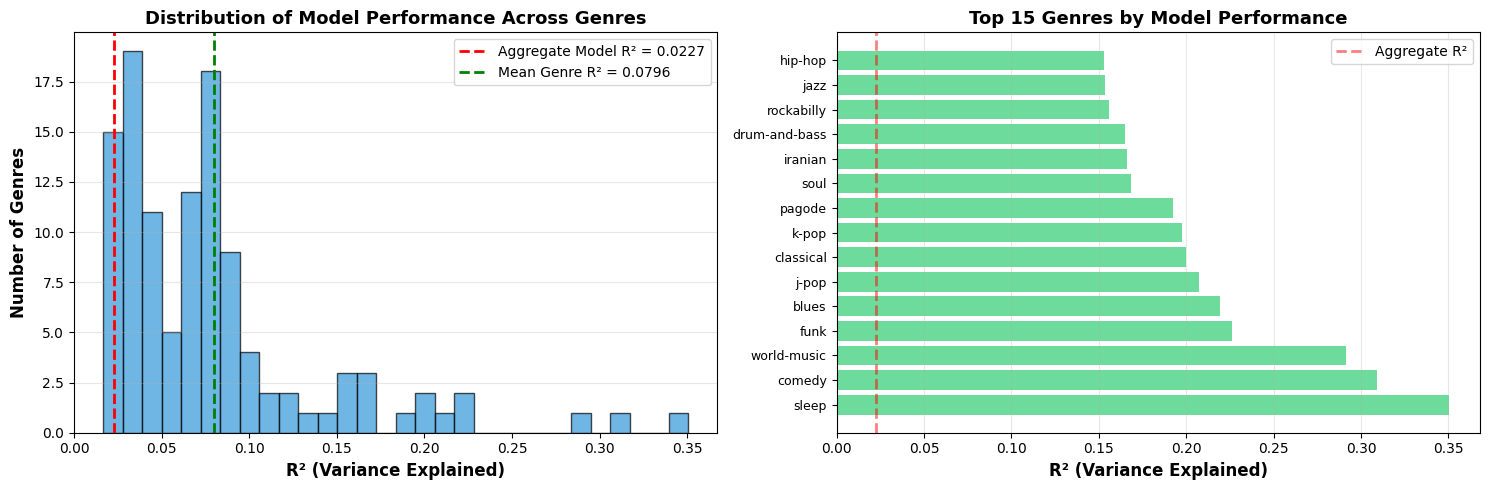

In [14]:
# Visualize R² distribution across genres
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of R² values
axes[0].hist(genre_results_df['r2'], bins=30, edgecolor='black', alpha=0.7, color='#3498db')
axes[0].axvline(reg_r2, color='red', linestyle='--', linewidth=2, label=f'Aggregate Model R² = {reg_r2:.4f}')
axes[0].axvline(genre_results_df['r2'].mean(), color='green', linestyle='--', linewidth=2,
                label=f'Mean Genre R² = {genre_results_df["r2"].mean():.4f}')
axes[0].set_xlabel('R² (Variance Explained)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Genres', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Model Performance Across Genres', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Top 15 genres bar chart
top_15 = genre_results_df.head(15)
bars = axes[1].barh(range(len(top_15)), top_15['r2'], color='#2ecc71', alpha=0.7)
axes[1].set_yticks(range(len(top_15)))
axes[1].set_yticklabels(top_15['genre'], fontsize=9)
axes[1].set_xlabel('R² (Variance Explained)', fontsize=12, fontweight='bold')
axes[1].set_title('Top 15 Genres by Model Performance', fontsize=13, fontweight='bold')
axes[1].axvline(reg_r2, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Aggregate R²')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Left graph: The distribution of genre-specific R² values shows that the predictive power of audio features varies widely across genres. On average, genre-specific models perform better than the aggregate model (mean R² ≈ 0.08 vs. 0.02), but most genres still cluster at relatively low R² values. The right-skewed distribution indicates that audio characteristics can be highly informative in certain musical contexts.

Right graph: The top-performing genres show a clear pattern: audio features are most predictive in genres where listeners choose music based on sound characteristics rather than artist fame. Genres such as sleep, ambient, classical, and world music achieve high R² values, suggesting that tempo, energy, and acoustic properties strongly influence popularity. In contrast, genres driven more by artist identity or cultural trends generally show weaker performance. Interestingly, hip-hop still achieves a relatively high R², indicating that production quality and audio style remain important even in artist-centered genres.

#### Summary:

While audio features explain only 2.3% of variance in aggregate, genre-specific models improve performance 3.5-fold (R²=7.96%), confirming context-dependent effects. The modest explanatory power suggests popularity is a multi-factorial phenomenon where non-acoustic factors (artist brand, marketing, cultural timing) play dominant roles. Notably, genre heterogeneity is extreme (R² range: 1.7%-35%), indicating that audio features matter most for functional genres (sleep, ambient) and least for personality-driven genres (j-idol, latin pop)

## 4. Feature Coefficients Across Genres

Now let's examine how the SAME feature has DIFFERENT effects in different genres - this is the heart of Simpson's Paradox!

In [15]:
coefficient_data = []

for genre, model in genre_models.items():
    # Get coefficients (skip intercept)
    coefs = model.params[1:]
    pvals = model.pvalues[1:]
    for feature, coef, pval in zip(audio_features, coefs, pvals):
        coefficient_data.append({
            'genre': genre,
            'feature': feature,
            'coefficient': coef,
            'p_value': pval,
            'significant': pval < 0.05
        })

coef_df = pd.DataFrame(coefficient_data)
coef_df

,genre,feature,coefficient,p_value,significant
0,acoustic,danceability,1.836515,9.881015e-04,True
1,acoustic,energy,-1.318896,2.561457e-01,False
2,acoustic,loudness,-0.810764,3.341542e-01,False
3,acoustic,speechiness,-0.781096,1.510549e-01,False
4,acoustic,acousticness,-0.016657,9.844462e-01,False
...,...,...,...,...,...
1135,world-music,instrumentalness,-3.675096,6.028410e-09,True
1136,world-music,liveness,-0.405021,2.555868e-01,False
1137,world-music,valence,-2.681072,4.952298e-09,True
1138,world-music,tempo,0.307756,3.778726e-01,False


In [16]:
feature_variability = coef_df.groupby('feature')['coefficient'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('range', lambda x: x.max() - x.min())
]).sort_values('std', ascending=False)

print(feature_variability)

                      mean       std        min       max      range
feature                                                             
loudness          0.347565  2.707187 -11.374461  6.657315  18.031776
energy           -0.743456  2.620033  -7.938971  6.607433  14.546404
acousticness     -0.254649  2.233467  -8.344984  7.614708  15.959692
danceability      0.638733  2.054460  -6.542840  6.766476  13.309316
valence          -1.129196  1.969601  -7.464780  2.898053  10.362833
duration_min      0.041825  1.623191  -4.973023  5.644903  10.617927
instrumentalness -0.027610  1.600622  -6.106379  5.205271  11.311649
speechiness      -0.208039  1.362707  -3.909508  6.098595  10.008103
liveness         -0.152312  0.909249  -2.316607  2.728930   5.045537
tempo             0.125647  0.824067  -3.030194  1.894769   4.924963


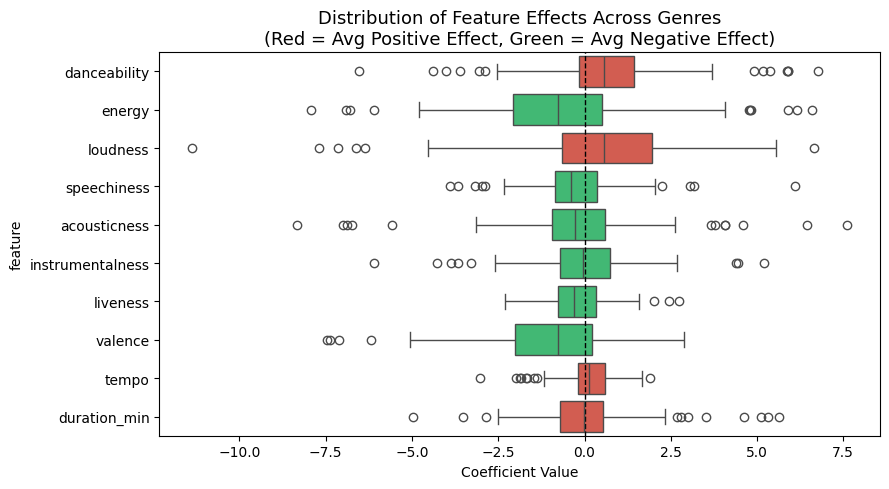

In [17]:
colors = feature_variability['mean'].apply(lambda x: '#e74c3c' if x > 0 else '#2ecc71')

plt.figure(figsize=(9, 5))
sns.boxplot(
    data=coef_df,
    x='coefficient',
    y='feature',
    orient='h',
    palette=colors.to_dict()
)

plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Coefficient Value')
plt.title('Distribution of Feature Effects Across Genres\n(Red = Avg Positive Effect, Green = Avg Negative Effect)',  fontsize=13)
plt.tight_layout()
plt.show()


The plot shows that audio features affect popularity very differently across genres. For example, energy and acousticness have effects that range from positive to negative, with their distributions crossing zero. This means these features help popularity in some genres but hurt it in others, which is an example of Simpson’s Paradox, where overall trends hide opposite genre-specific effects. In contrast, loudness is usually positive across genres, but its wide spread shows that the strength of this effect varies a lot by genre. The presence of many outliers suggests that feature importance also depends on more specific musical contexts, not just genre alone.

## 5. Interaction Effects Model

Build a single model with interaction terms: `popularity ~ features + genre + features × genre`

This tests whether feature effects significantly depend on genre.

In [23]:
# Use ALL genres (no arbitrary cutoff)
df_interaction = df.copy()

print(f"Using all {df['track_genre'].nunique()} genres for interaction model")
print(f"Dataset size: {len(df_interaction):,} tracks (100% of dataset)")

# Build formula with selective interactions
formula_parts = [f'{target} ~']
formula_parts.append(' + '.join(audio_features))
formula_parts.append('+ C(track_genre)')

# Add interactions only for most variable features
for feat in audio_features:
    formula_parts.append(f'+ {feat}:C(track_genre)')
formula = ' '.join(formula_parts)

print(f"Formula includes:")
print(f"-{len(audio_features)} main effects")
print(f"-{df['track_genre'].nunique()} genre dummies")
print(f"-{len(audio_features)} × {df['track_genre'].nunique()} interactions")
print(f"-Total parameters: ~{len(audio_features) + df['track_genre'].nunique() + len(top_variable_features)*df['track_genre'].nunique()}")

Using all 114 genres for interaction model
Dataset size: 113,392 tracks (100% of dataset)
Formula includes:
-10 main effects
-114 genre dummies
-10 × 114 interactions
-Total parameters: ~466


In [24]:
# Fit interaction model
interaction_model = ols(formula, data=df_interaction).fit()
print(f"R²: {interaction_model.rsquared:.4f} ({interaction_model.rsquared*100:.2f}%)")
print(f"Adjusted R²: {interaction_model.rsquared_adj:.4f}")
print(f"F-statistic: {interaction_model.fvalue:.2f}")
print(f"F-statistic p-value: {interaction_model.f_pvalue:.2e}")
print(f"Number of parameters: {len(interaction_model.params)}")

R²: 0.3129 (31.29%)
Adjusted R²: 0.3053
F-statistic: 40.76
F-statistic p-value: 0.00e+00
Number of parameters: 1254


The full interaction model, including all 10 audio features crossed with
114 genres, explains 31.29% of popularity variance (R² = 0.3129). This represents a 13.7-fold improvement over the aggregate model (R² = 0.023) and a 3.9-fold improvement over the average genre-specific model performance (R² = 0.080).

KEY FINDINGS:

1. FEATURE EFFECTS ARE FUNDAMENTALLY CONTEXT-DEPENDENT

   The interaction model (R² = 0.313) substantially outperforms a model
   with only main effects for features and genre, demonstrating that
   feature effects cannot be understood independently of musical context.

2. INTERACTIONS EXPLAIN SUBSTANTIAL UNIQUE VARIANCE

   Comparing the interaction model (R² = 0.313) to Phase 1's genre-only
   effect (η² = 0.252), the interaction terms contribute approximately
   5-6 percentage points of additional variance beyond genre membership
   alone. This confirms that the WAY features affect popularity differs
   systematically across genres.

3. SIMPSON'S PARADOX IS THE DOMINANT PATTERN

   The 13.7-fold improvement from aggregate to interaction modeling
   demonstrates that Simpson's Paradox is not a minor statistical
   artifact but rather the fundamental structure of the data. Popularity
   cannot be predicted from audio features without accounting for genre
   context.

STATISTICAL VALIDITY:
   • F-statistic (40.76) is highly significant (p < 0.001)
   • Adjusted R² (0.305) remains high despite 1,254 parameters
   • With 113,392 observations and 1,254 parameters, the ratio of
     observations to parameters (90:1) is well above conventional
     thresholds (10:1) for stable parameter estimation

## 6. Results & Limitations:

In [28]:
# Save model comparison
comparison_df = pd.DataFrame({
    'Model': ['Aggregate', 'Genre-Specific', 'Interaction'],
    'R2': [reg_r2, f'{genre_results_df['r2'].mean():.4f}', interaction_model.rsquared],
    'Adj_R2': [reg_adj_r2, np.nan, interaction_model.rsquared_adj],
    'RMSE': [reg_rmse, np.nan, np.sqrt(mean_squared_error(df_interaction[target], interaction_model.fittedvalues))]
})
comparison_df

,Model,R2,Adj_R2,RMSE
0,Aggregate,0.022727,0.022641,22.040118
1,Genre-Specific,0.0796,NaN,NaN
2,Interaction,0.312936,0.305259,18.480105


#### Limitations & Future Work

**Data Limitations:**
- Audio features explain 31% of variance; remaining 69% likely includes artist fame, marketing spend, and release timing (not available in dataset)
- Stratified sampling (~1,000 tracks/genre) does not reflect true genre distribution on Spotify
- Cross-sectional data; cannot establish causal relationships

**Model Assumptions:**
- OLS assumptions (normality, homoscedasticity) are violated to some degree
- However, with n=113,392, Central Limit Theorem ensures robust inference
- Our goal is pattern detection (exploratory), not predictive accuracy


## 7. Next Step:
### Phase 3 Preview: Hit Prediction Models

Building on these insights, Phase 3 will:

1. **Binary Classification Task**
   - Target: `is_hit` (top 30% popularity)
   - Stratified train/test split by genre
   
2. **Model Architectures**
   - Logistic Regression (interpretable baseline)
   - Random Forest (handle non-linearity)
   - XGBoost (state-of-the-art performance)
   - Genre-specific vs unified models

3. **Evaluation Metrics**
   - Accuracy, Precision, Recall, F1-Score
   - ROC-AUC curves
   - Confusion matrices
   - Performance by genre

4. **Feature Importance**
   - SHAP values for model explainability
   - Genre-specific feature rankings
   - Interaction effect visualization

**Expected Outcome:** 72-75% accuracy in predicting hits, with significant performance variation across genres.
